In [2]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

In [3]:
# Load YOLO model
model=YOLO("yolo11n.pt")

In [4]:
def track(s):
    # Initialize video capture and background
    video=cv2.VideoCapture(s)
    ret, background=video.read()
    if ret:
        background=cv2.resize(background, (640, 384))

    # Tracking parameters
    movement={}  # Dictionary to store paths for each person
    next_id=1  # Unique ID for each person
    max_distance=50  # Maximum distance to match detections to existing tracks
    
    while True:
        ret, frame=video.read()
        if not ret:
            break

        frame=cv2.resize(frame, (640, 384))
        results=model(frame)
        detected_people=[]  # Store current frame's detections

        # Parse the detection results
        for result in results:
            for box in result.boxes:
                if int(box.cls[0]) == 0:  # 0 is the class ID for 'person'
                    x1, y1, x2, y2=map(int, box.xyxy[0])  # Extract bounding box
                    feet_x=int((x1+x2)/2)  # Calculate feet position
                    feet_y=y2
                    detected_people.append((feet_x, feet_y))

        # Match detections to existing tracks
        updated_movement={}
        for person_id, path in movement.items():
            last_position=path[-1]  # Last recorded position of the person
            matched=False

            # Match current detections to the person's last position
            for idx, (feet_x, feet_y) in enumerate(detected_people):
                distance=np.linalg.norm(np.array(last_position)-np.array((feet_x, feet_y)))
                if distance<max_distance:  # Match found
                    updated_movement[person_id]=path+[(feet_x, feet_y)]
                    detected_people.pop(idx)  # Remove matched detection
                    matched=True
                    break

            # If no match, keep the path as is
            if not matched:
                updated_movement[person_id]=path

        # Assign new IDs to unmatched detections
        for feet_x, feet_y in detected_people:
            updated_movement[next_id]=[(feet_x, feet_y)]
            next_id+=1

        movement=updated_movement

    video.release()

    # Convert the background to RGB for matplotlib
    background_rgb=cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
    return background_rgb, movement


In [5]:
def printPath(a, b):
    # Plot the paths on the background image
    plt.figure(figsize=(10, 6))
    plt.imshow(a)

    # Plot each person's path with a unique color
    for person_id, path in b.items():
        path=np.array(path)
        if len(path)>0:
            plt.plot(path[:, 0], path[:, 1], label=f'Person {person_id}')

    plt.legend()
    plt.title("Paths of Detected People")
    plt.show()

In [6]:
def printSingle(a, b):
    plt.figure(figsize=(10, 6))
    plt.imshow(a)
    plt.plot(b[:, 0], b[:, 1], 'r-')
    plt.show()

In [7]:
background_rgb_ver, movement2_ver=track('Feed/TopFeed.mp4')


0: 384x640 4 persons, 1 surfboard, 344.0ms
Speed: 16.0ms preprocess, 344.0ms inference, 32.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 surfboard, 176.0ms
Speed: 8.0ms preprocess, 176.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 surfboard, 120.0ms
Speed: 8.0ms preprocess, 120.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 surfboard, 208.1ms
Speed: 0.0ms preprocess, 208.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 surfboard, 152.0ms
Speed: 8.0ms preprocess, 152.0ms inference, 16.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 surfboard, 753.8ms
Speed: 24.0ms preprocess, 753.8ms inference, 40.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 surfboard, 113.3ms
Speed: 8.0ms preprocess, 113.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



In [8]:
mov_ver=np.array(movement2_ver[2])

In [9]:
r=np.arange(-20, 0)
x=np.delete(mov_ver, r, axis=0)

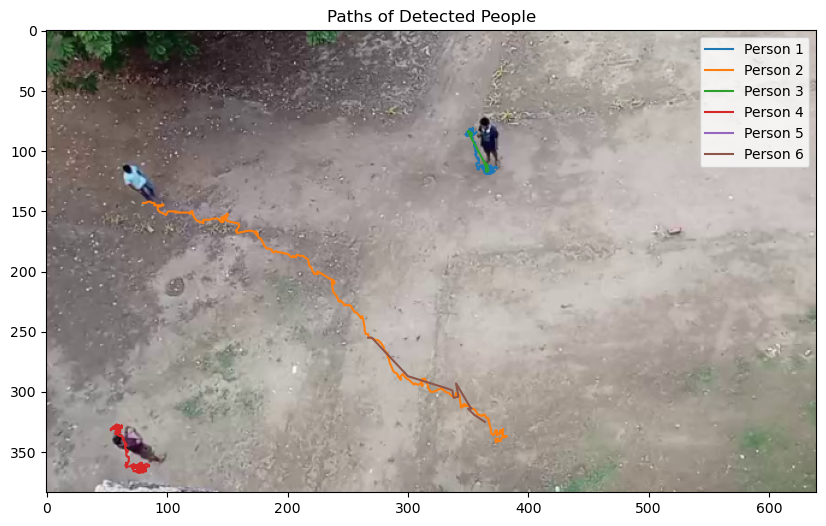

In [10]:
printPath(background_rgb_ver, movement2_ver)

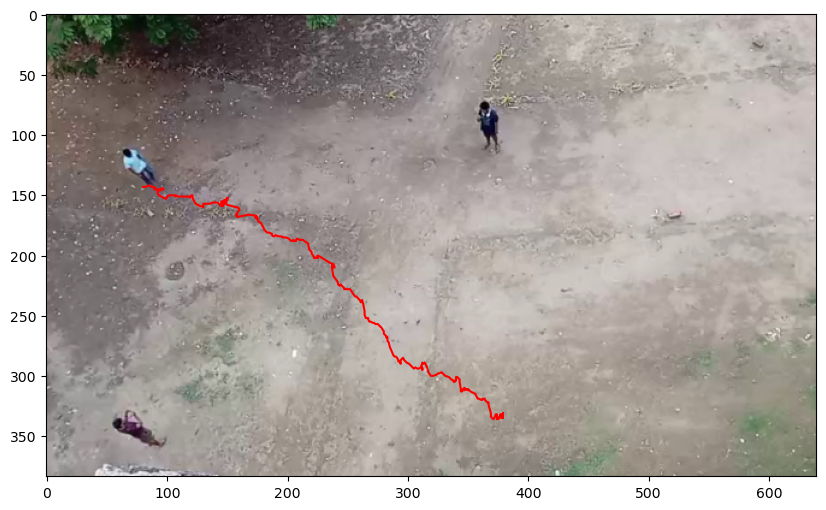

In [11]:
printSingle(background_rgb_ver, x)

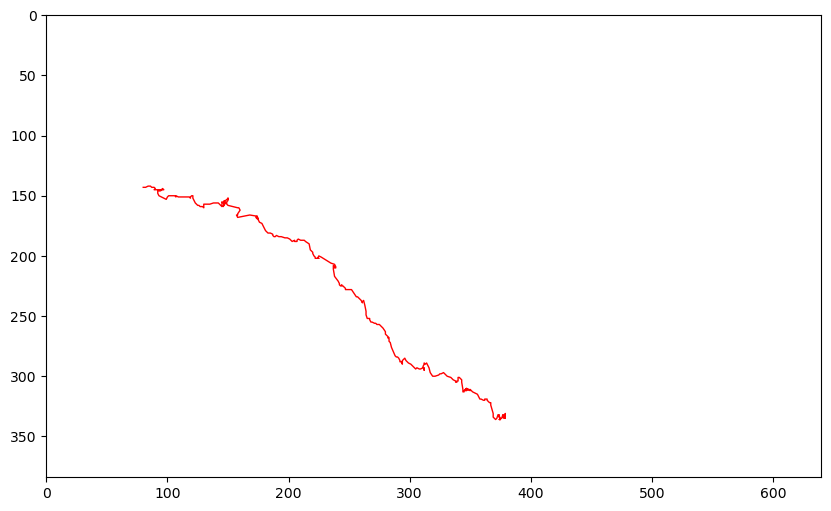

In [12]:
# Create a blank figure (without the background)
fig=plt.figure(figsize=(10, 6))
x=np.array(x)
plt.plot(x[:, 0], x[:, 1], 'r-', markersize=1, linewidth=1)
plt.xlim(0, 640)
plt.ylim(384, 0)
plt.show()

In [13]:
np.save('check_points.npy', x)